In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Helper functions

In [2]:
def load_emails(folder):

    # Read all email filenames into a list
    spam_filenames = [email_text for email_text in sorted(os.listdir(folder))]

    """
    Loop through all files in spam_filenames
    Open the file via a file handle. For info: https://www.programiz.com/python-programming/file-operation
    Read the contents into a list where each line in the file is an element of the list
    Append the email content into the all_contents list
    """

    all_contents = []

    for filename in spam_filenames:
        with open(os.path.join(folder,filename), encoding="Latin-1") as f:
            contents = f.readlines()
            all_contents.append(contents)

    """
    Note that all_contents is a list of lists. Here we flatten it into a list of strings
    """
    all_contents_flat = [' '.join(email) for email in all_contents]

    # Load all_contents_flat into a pandas dataframe
    df = pd.DataFrame({'email_text': all_contents_flat})
    
    return df


def evaluate_predictions(y_test, y_pred):
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('\n Classification Report:\n',classification_report(y_test, y_pred))

## Load dataset

In [3]:
#The following works if your notebook is in a folder that contains a subfolder /enron1/ham/
# with in each a series of email data files like 0006.2003-12-18.GP.spam.txt etc
SPAM_DIR = './enron1/spam/'
HAM_DIR = './enron1/ham/'

In [4]:
ham_df = load_emails(HAM_DIR)
ham_df['class'] = 'ham'
spam_df = load_emails(SPAM_DIR)
spam_df['class'] = 'spam'

In [5]:
df = pd.concat([ham_df, spam_df])

In [6]:
df['class'].value_counts()

ham     3672
spam    1500
Name: class, dtype: int64

In [7]:
df.head()

,email_text,class
0,Subject: christmas tree farm pictures\n,ham
1,"Subject: vastar resources , inc .\n gary , pro...",ham
2,Subject: calpine daily gas nomination\n - calp...,ham
3,Subject: re : issue\n fyi - see note below - a...,ham
4,Subject: meter 7268 nov allocation\n fyi .\n -...,ham


In [8]:
df = df.sample(frac=.2)

### Preprocess text data

In [9]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package words to /Users/paolo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/paolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/paolo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def clean_email_text(email_array):
    
    # Tokenize as words
    processed_array = [word_tokenize(email) for email in email_array]
  
    # [['a', word'], ['another']]
    
    # Keep only alphabetic tokens
    # Remove stopwords
    processed_array = [[word for word in email if (word.isalpha()) & (word not in stopwords.words('english'))] \
                       for email in processed_array]
    # [['word'], ['another']]
    
    # Lemmatize
    # For more info: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    lemmatizer = WordNetLemmatizer()
    processed_array = [[lemmatizer.lemmatize(word) for word in email] for email in processed_array]
    
    # Flatten back into a string
    processed_array = [' '.join(email) for email in processed_array]
    
    return processed_array
    

In [11]:
test = ["A fox and foxes are all just a fox", "Another email"]

In [12]:
clean_email_text(test)

['A fox fox fox', 'Another email']

In [13]:
df['clean_email'] = clean_email_text(df['email_text'].values)

In [14]:
df.head()

,email_text,class,clean_email
208,Subject: guaranteed satisfaction ! great price...,spam,Subject guaranteed satisfaction great price
339,Subject: cdnow shipment confirmation\n dear da...,ham,Subject cdnow shipment confirmation dear daren...
1184,"Subject: hpl nom for july 14 , 2000\n ( see at...",ham,Subject hpl nom july see attached file hplo xl...
79,Subject: security warning\n,spam,Subject security warning
708,Subject: may golf specials ! !\n welcome & enj...,ham,Subject may golf special welcome enjoy kingwoo...


## Model training

### Train test split

In [15]:
from sklearn.model_selection import train_test_split

y = (df['class']=='spam').values
X_train, X_test, y_train, y_test = train_test_split(df['clean_email'], y, test_size=0.33, random_state=21)

### Train a model - the blind way

#### Feature engineering (bag of words)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [18]:
# Fit a default naive bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(count_train, y_train) 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
# Evaluate on test data
y_pred = nb.predict(count_test)

In [20]:
evaluate_predictions(y_test,y_pred)

Accuracy score:  0.9444444444444444

Confusion Matrix:
 [[218   5]
 [ 14 105]]

 Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.98      0.96       223
        True       0.95      0.88      0.92       119

   micro avg       0.94      0.94      0.94       342
   macro avg       0.95      0.93      0.94       342
weighted avg       0.94      0.94      0.94       342



In [21]:
# Rank spamness of words
words = np.array(count_vectorizer.get_feature_names())

x = np.eye(count_train.shape[1])
probs = nb.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

spam_words = words[ind[:20]]
ham_words = words[ind[-20:]]

print("Ham words:\n",ham_words)
print("Spam words:\n",spam_words)

Ham words:
 ['pat' 'pm' 'gary' 'allocation' 'july' 'hou' 'nom' 'volume' 'nomination'
 'sitara' 'farmer' 'forwarded' 'ect' 'pec' 'mmbtu' 'hpl' 'daren' 'cc'
 'meter' 'enron']
Spam words:
 ['computron' 'viagra' 'cialis' 'de' 'prescription' 'gb' 'xp' 'pain' 'pro'
 'soft' 'drug' 'adobe' 'php' 'pill' 'medication' 'ur' 'hot' 'spam'
 'removed' 'ali']


### Train a model - hyperparamter tuning

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
parameter_candidates = [{'alpha': np.arange(0.01,1.5,.1)}]

In [24]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=MultinomialNB(), param_grid=parameter_candidates, n_jobs=-1, cv=3)

In [25]:
# Train the classifier 
clf.fit(count_train, y_train)  

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
# View the accuracy score
print('Best score ', clf.best_score_, ', Best params:',  clf.best_params_) 

Best score  0.9739884393063584 , Best params: {'alpha': 0.01}


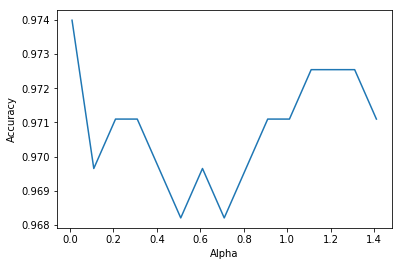

In [27]:
plt.plot([i['alpha'] for i in clf.cv_results_['params']], clf.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

In [28]:
# Evaluate on test data
y_pred = clf.predict(count_test)
evaluate_predictions(y_test, y_pred)

Accuracy score:  0.9619883040935673

Confusion Matrix:
 [[218   5]
 [  8 111]]

 Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97       223
        True       0.96      0.93      0.94       119

   micro avg       0.96      0.96      0.96       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342



### Train a model - hyperparamter tuning using Pipeline

In [29]:
from sklearn.pipeline import Pipeline

In [30]:
pipeline = Pipeline([('counts', CountVectorizer()),('classifier', MultinomialNB())])

In [31]:
parameter_space = {
                    'counts__min_df': [0, 0.02, 0.05],
                    'classifier__alpha': np.arange(0.01,1.5,.1)
                    }

In [32]:
pipe_grid = GridSearchCV(pipeline, parameter_space, cv=3, n_jobs=-1)

In [33]:
# Train the classifier via GridSearcCV
pipe_grid.fit(X_train, y_train)  

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocess...one, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'counts__min_df': [0, 0.02, 0.05], 'classifier__alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
# View the accuracy score
print('Best score ', pipe_grid.best_score_, ', Best params:',  pipe_grid.best_params_) 

Best score  0.9682080924855492 , Best params: {'classifier__alpha': 0.11, 'counts__min_df': 0}


In [35]:
# Evaluate on test data
y_pred = pipe_grid.predict(X_test)
evaluate_predictions(y_test, y_pred)

Accuracy score:  0.9649122807017544

Confusion Matrix:
 [[218   5]
 [  7 112]]

 Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.97       223
        True       0.96      0.94      0.95       119

   micro avg       0.96      0.96      0.96       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342



### Choosing your model with GridSearchCV and Pipeline

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [37]:
pipe = Pipeline([('counts', CountVectorizer()), 
                 ('preprocessing', StandardScaler()), 
                 ('classifier', SVC())])

In [38]:
param_grid = [
    {'counts':[TfidfVectorizer(), CountVectorizer()], 
     'classifier': [MultinomialNB()], 
     'preprocessing': [None],
     'classifier__alpha': np.arange(0.01,1.5,.1)},
    {'counts':[TfidfVectorizer(), CountVectorizer()], 
     'classifier': [SVC()], 
     'preprocessing': [StandardScaler(with_mean=False), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'counts':[TfidfVectorizer(), CountVectorizer()], 
     'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 
     'classifier__max_features': [1, 2], 
     'classifier__max_depth': [1,2]}]

In [39]:
clf = GridSearchCV(pipe, param_grid, cv=3,n_jobs=-1)

In [41]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'counts': [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_id...se)], 'preprocessing': [None], 'classifier__max_features': [1, 2], 'classifier__max_depth': [1, 2]}],
       pre_dispatch='2*n_jobs', refit=T

In [48]:
for param_combo in clf.cv_results_['params']:
    print(param_combo)
    print('***')

{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'classifier__alpha': 0.01, 'counts': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'preprocessing': None}
***
{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'classifier__alpha': 0.01, 'counts': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, to

In [42]:
print("Best params:\n{}\n".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.1, 'counts': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'preprocessing': None}

Best cross-validation score: 0.97


In [43]:
# Evaluate on test data
y_pred = clf.predict(X_test)
evaluate_predictions(y_test, y_pred)

Accuracy score:  0.9736842105263158

Confusion Matrix:
 [[218   5]
 [  4 115]]

 Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.98      0.98       223
        True       0.96      0.97      0.96       119

   micro avg       0.97      0.97      0.97       342
   macro avg       0.97      0.97      0.97       342
weighted avg       0.97      0.97      0.97       342

